In [1]:
# Step 0: Imports
import pandas as pd
import numpy as np
from pathlib import Path

data = Path("/Users/hesamakbari/Desktop/distress_download.csv")  # your downloaded file



Loaded shape: (3, 1)
Columns: ['ECONOMIC DISTRESS CRITERIA']
Renamed columns mapping: {'ECONOMIC DISTRESS CRITERIA': 'economic_distress_criteria'}
Saved cleaned CSV to: /Users/hesamakbari/Desktop/outputs/distress_clean.csv
Applied tweak: reordered columns and filled numeric NaNs with 0 (adjust if unwanted).
Saved tweaked CSV to: /Users/hesamakbari/Desktop/outputs/distress_clean_tweaked.csv
Saved schema.json with inferred dtypes.
Use the companion R script 'distress_pipeline_replicate.R' to replicate in R.
Saved long format CSV for plotting to: /Users/hesamakbari/Desktop/outputs/distress_long_for_plot.csv


/var/folders/2f/fyp7zqzx5sx0fm12n54hmpn40000gn/T/ipykernel_66100/1301300392.py:266: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


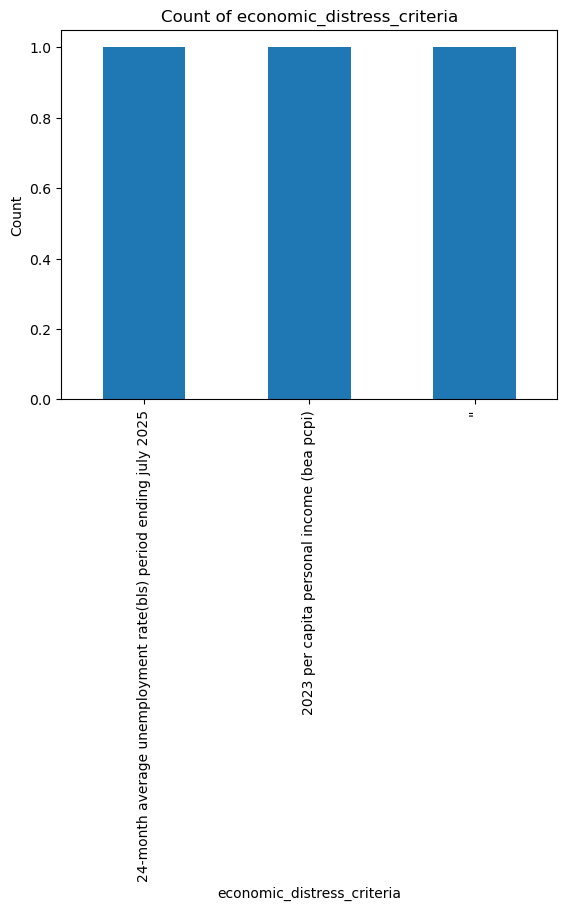

In [5]:

# =========================================
# Distress Data Cleaning & Shaping Pipeline
# Steps 2–12 implemented in Python for Jupyter
# =========================================

# Cell 1: Imports & Paths (Step 0 already done by you)
import pandas as pd
import numpy as np
import re
from pathlib import Path

# Adjust this path to your local file location if needed
DATA_PATH = Path("/Users/hesamakbari/Desktop/distress_download.csv")  # or "/mnt/data/distress_download.csv"
OUT_DIR   = Path("./outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Utility: robust CSV reader ----------
def robust_read_csv(path: Path):
    """
    Try multiple strategies to open a messy CSV with unknown delimiter/quotes.
    """
    # Try fast path first
    try:
        return pd.read_csv(path)
    except Exception:
        pass

    # Try python engine + auto sep
    try:
        return pd.read_csv(path, engine="python", sep=None)
    except Exception:
        pass

    # Try a set of common delimiters and quoting options
    candidates = [
        dict(sep=","),
        dict(sep=";"),
        dict(sep="\t"),
        dict(sep="|"),
    ]
    quotechars = ['"', "'", None]

    for cand in candidates:
        for qc in quotechars:
            try:
                df = pd.read_csv(path, engine="python", on_bad_lines="skip", quoting=3 if qc is None else None, **cand)
                if df.shape[1] > 1 or df.shape[0] > 1:
                    return df
            except Exception:
                continue

    # As a last resort, read as a single column and try to split
    raw = pd.read_csv(path, header=None, engine="python", on_bad_lines="skip")
    return raw

# Cell 2: Load data (Step 2: Preparing ChatGPT with a query and data)
df = robust_read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))
df.head(10)

# Cell 3: "ChatGPT's description of our data" (Step 3)
# -> We will generate a quick auto-profile: dtypes, missing values, sample stats.
def quick_describe(frame: pd.DataFrame, max_unique_for_cats=50):
    info = {
        "n_rows": len(frame),
        "n_cols": frame.shape[1],
        "dtypes": frame.dtypes.astype(str).to_dict(),
        "missing_pct": frame.isna().mean().round(4).to_dict(),
    }
    # Detect "likely categorical" columns
    likely_cats = []
    for c in frame.columns:
        nunique = frame[c].nunique(dropna=True)
        if nunique <= max_unique_for_cats:
            likely_cats.append((c, nunique))
    info["likely_categoricals"] = likely_cats
    return info

profile = quick_describe(df)
profile

# Cell 4: Rename columns based on other columns (Step 4)
# Heuristic renaming:
# - strip spaces
# - unify to snake_case
# - de-duplicate names
def to_snake(s: str) -> str:
    s = re.sub(r"[^\w\s]+", " ", str(s)).strip().lower()
    s = re.sub(r"\s+", "_", s)
    return s

def dedupe_columns(cols):
    seen = {}
    out = []
    for c in cols:
        base = c
        if base not in seen:
            seen[base] = 0
            out.append(base)
        else:
            seen[base] += 1
            out.append(f"{base}__{seen[base]}")
    return out

orig_cols = list(df.columns)
new_cols = [to_snake(c) for c in orig_cols]
new_cols = dedupe_columns(new_cols)
rename_map = dict(zip(orig_cols, new_cols))
df = df.rename(columns=rename_map)
print("Renamed columns mapping:", rename_map)
df.head(5)

# Optional: If you have a "code/name" pair to merge (e.g., "county_code" + "county_name"),
# uncomment and adapt this example:
# if {"county_code","county_name"} <= set(df.columns):
#     df["county"] = df["county_code"].astype(str).str.zfill(3) + " - " + df["county_name"].astype(str)
#     df = df.drop(columns=["county_code","county_name"])

# Cell 5: Format the columns (Step 5)
# - Trim whitespace from strings
# - Parse dates when columns look like dates
# - Coerce numeric-like strings to numbers
def soft_parse_dates(frame: pd.DataFrame, candidate_max=10):
    for col in frame.columns:
        if frame[col].dtype == object:
            sample = frame[col].dropna().astype(str).head(candidate_max)
            if sample.empty:
                continue
            # simple date heuristic
            if sample.str.contains(r"\d{4}[-/]\d{1,2}[-/]\d{1,2}", regex=True).any():
                try:
                    frame[col] = pd.to_datetime(frame[col], errors="coerce", infer_datetime_format=True)
                except Exception:
                    pass
    return frame

def trim_object_strings(frame: pd.DataFrame):
    obj_cols = frame.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        frame[col] = frame[col].astype(str).str.strip()
        # convert empty strings to NaN
        frame[col] = frame[col].replace({"": np.nan})
    return frame

def coerce_numeric(frame: pd.DataFrame):
    # Try to coerce non-date object columns to numeric if >50% of non-null values are numeric-like
    obj_cols = [c for c in frame.columns if frame[c].dtype == object]
    for col in obj_cols:
        s = frame[col].dropna().astype(str)
        if len(s) == 0:
            continue
        numeric_like = s.str.match(r"^[-+]?\d*\.?\d+(e[-+]?\d+)?$", case=False, na=False).mean()
        if numeric_like > 0.5:
            frame[col] = pd.to_numeric(frame[col], errors="coerce")
    return frame

df = trim_object_strings(df)
df = soft_parse_dates(df)
df = coerce_numeric(df)
df.head(10)

# Cell 6: Refining formatting (Step 6)
# - Standardize categorical case
# - Remove obvious duplicates
# - Handle common "yes/no" variants
def standardize_categoricals(frame: pd.DataFrame, to_lower=True, yes_no_map=True):
    obj_cols = frame.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        if to_lower:
            frame[col] = frame[col].str.lower()
        if yes_no_map:
            frame[col] = frame[col].replace({
                "y":"yes","n":"no",
                "true":"yes","false":"no",
                "1":"yes","0":"no"
            })
    return frame

df = standardize_categoricals(df)
df = df.drop_duplicates().reset_index(drop=True)
df.head(10)

# Cell 7: Make a comma-delimited file (Step 7)
clean_path = OUT_DIR / "distress_clean.csv"
df.to_csv(clean_path, index=False)
print(f"Saved cleaned CSV to: {clean_path.resolve()}")

# Cell 8: A few more formatting tweaks (Step 8)
# Example tweaks:
# - Reorder columns: put ID/date-like columns first
id_like = [c for c in df.columns if re.search(r"(id|uuid|guid)$", c)]
date_like = [c for c in df.columns if "date" in c]
others = [c for c in df.columns if c not in id_like + date_like]
new_order = id_like + date_like + others
df = df[new_order]

# - Fill remaining NaNs in numeric columns with 0 (if appropriate)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

# - Keep object NaNs as NaN to distinguish missing text
print("Applied tweak: reordered columns and filled numeric NaNs with 0 (adjust if unwanted).")
tweaked_path = OUT_DIR / "distress_clean_tweaked.csv"
df.to_csv(tweaked_path, index=False)
print(f"Saved tweaked CSV to: {tweaked_path.resolve()}")

# Cell 9: Finishing touches (Step 9)
# - Enforce consistent column types via schema inference
schema = {c: str(df[c].dtype) for c in df.columns}
with open(OUT_DIR / "schema.json", "w") as f:
    import json; json.dump(schema, f, indent=2)
print("Saved schema.json with inferred dtypes.")

# Cell 10: Replicate cleaning steps in R (Step 10)
# -> See the generated R script 'distress_pipeline_replicate.R' placed alongside this notebook.
print("Use the companion R script 'distress_pipeline_replicate.R' to replicate in R.")

# Cell 11: Reshape for graphing (Step 11)
# Strategy:
# - If multiple numeric columns: melt to long format
# - If there is a date column, keep it as id_var; otherwise keep the first categorical as id_var
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
date_cols = [c for c in df.columns if "date" in c or np.issubdtype(df[c].dtype, np.datetime64)]

if len(numeric_cols) >= 2:
    id_vars = []
    if date_cols:
        id_vars = date_cols
    else:
        # pick up to 2 categoricals as ids
        cats = df.select_dtypes(exclude=[np.number, "datetime64[ns]"]).columns.tolist()
        id_vars = cats[:2]
    long_df = df.melt(id_vars=id_vars, value_vars=numeric_cols, var_name="metric", value_name="value")
else:
    # If only one numeric, just copy
    long_df = df.copy()
long_path = OUT_DIR / "distress_long_for_plot.csv"
long_df.to_csv(long_path, index=False)
print(f"Saved long format CSV for plotting to: {long_path.resolve()}")
long_df.head(10)

# Cell 12: Quick Python graph (for inspection); the R script will make ggplots too (Step 12)
import matplotlib.pyplot as plt

# Simple heuristic plot:
if date_cols and len(numeric_cols) >= 1:
    plt.figure()
    df_sorted = df.sort_values(date_cols[0])
    plt.plot(df_sorted[date_cols[0]], df_sorted[numeric_cols[0]])
    plt.title(f"Time series of {numeric_cols[0]}")
    plt.xlabel(date_cols[0])
    plt.ylabel(numeric_cols[0])
    plt.tight_layout()
    plt.savefig(OUT_DIR / "quick_timeseries.png", dpi=150)
    plt.show()
else:
    # bar count of first categorical
    cats = df.select_dtypes(exclude=[np.number, "datetime64[ns]"]).columns.tolist()
    if cats:
        plt.figure()
        df[cats[0]].value_counts().plot(kind="bar")
        plt.title(f"Count of {cats[0]}")
        plt.xlabel(cats[0])
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "quick_bar.png", dpi=150)
        plt.show()


In [7]:

# ============================================================
# Generative-AI Assisted Data Quality Framework (Steps 1–4)
# ============================================================
# Use this in Jupyter by pasting cells or running as a script.
#
# What it does:
# 1) Define data quality dimensions & rules (config below)
# 2) Identify data quality issues (per column & cross-field)
# 3) Quantify issue rates per dimension
# 4) Compute an overall Data Quality Score (0–100) with weights
#
# "Generative AI" hooks:
#  - Where noted, you can prompt ChatGPT to propose rules, value lists,
#    or regex patterns based on your column samples and domain context.
#  - This script logs summary stats suitable for sharing with ChatGPT
#    to refine rules iteratively.
# ============================================================

# ---------- Imports ----------
import pandas as pd
import numpy as np
import json
import re
from pathlib import Path
from datetime import datetime, timedelta

# ---------- Paths ----------
# If you're running locally, change DATA_PATH to your file path.
# The code attempts to robustly load messy CSVs.
CANDIDATE_PATHS = [
    Path("/Users/hesamakbari/Desktop/distress_download.csv"),
    Path("/mnt/data/distress_download.csv"),   # fallback if running here
]
OUT_DIR = Path("./dq_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Robust CSV reader ----------
def robust_read_csv(path: Path) -> pd.DataFrame:
    # Try simple
    try:
        return pd.read_csv(path)
    except Exception:
        pass
    # Try python engine sep=None
    try:
        return pd.read_csv(path, engine="python", sep=None)
    except Exception:
        pass
    # Try common delimiters
    for sep in [",",";","\t","|"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python", on_bad_lines="skip")
            if df.shape[1] > 1:
                return df
        except Exception:
            continue
    # Fallback
    return pd.read_csv(path, header=None, engine="python", on_bad_lines="skip")

def pick_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return paths[0]

DATA_PATH = pick_existing(CANDIDATE_PATHS)

# ---------- Step 1: Define data quality dimensions via config ----------
# Customize this CONFIG to your data. Use ChatGPT to help fill rules:
# Example prompt: "From these column samples and units, propose value ranges,
# allowed categories, and regex validators."

CONFIG = {
    # IMPORTANT: Fill these lists with your real column names
    "id_columns": [],       # e.g., ["record_id"]
    "date_columns": [],     # e.g., ["report_date"]
    "weights": {            # weights for final score (sum doesn't need to be 1; we'll normalize)
        "completeness": 1.0,
        "uniqueness":   1.0,
        "validity":     1.0,
        "consistency":  1.0,
        "timeliness":   0.5
    },
    # Validity rules
    "numeric_rules": {
        # "age": {"min": 0, "max": 120, "allow_na": False}
    },
    "categorical_rules": {
        # "sex": {"allowed": ["male","female","other"]}
    },
    "regex_rules": {
        # "email": r"^[^@\s]+@[^@\s]+\.[^@\s]+$"
    },
    # Consistency (cross-field) rules expressed as pandas query filters that indicate "valid rows".
    # Any row NOT matching the query is considered inconsistent.
    "consistency_rules": [
        # e.g., "start_date <= end_date", "cases >= recovered"
    ],
    # Timeliness options
    "timeliness": {
        "max_future_days": 0,       # dates should not be in the future beyond this
        "max_age_days": None        # if set, dates older than this are considered stale
    },
}

# ---------- Load data ----------
df = robust_read_csv(DATA_PATH)
df = df.copy()
print(f"Loaded: {DATA_PATH} shape={df.shape}")
df_sample = df.head(20)
df_sample.to_csv(OUT_DIR / "sample_head.csv", index=False)

# ---------- Basic normalization for object columns ----------
# Trim whitespace, normalize obvious empty strings -> NaN
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].replace({"": np.nan})

# Try soft date parse for declared date columns
for col in CONFIG["date_columns"]:
    if col in df.columns:
        try:
            df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
        except Exception:
            pass

# ---------- Helper functions for dimensions ----------
def completeness_metrics(frame: pd.DataFrame):
    nonnull = 1.0 - frame.isna().mean()
    return nonnull.to_dict(), nonnull.mean()

def uniqueness_metrics(frame: pd.DataFrame, id_cols: list):
    if not id_cols:
        return {"note": "no id_columns defined"}, np.nan
    ok = []
    detail = {}
    for key in id_cols:
        if key not in frame.columns:
            detail[key] = {"error": "missing column"}
            continue
        pct_unique = frame[key].nunique(dropna=False) / len(frame) if len(frame) else np.nan
        dup_count = len(frame) - frame[key].nunique(dropna=False)
        detail[key] = {"pct_unique": float(pct_unique), "duplicates": int(dup_count)}
        ok.append(pct_unique)
    score = np.nanmean(ok) if ok else np.nan
    return detail, score

def validity_metrics(frame: pd.DataFrame, numeric_rules, categorical_rules, regex_rules):
    issues = []
    checks = []
    # Numeric ranges
    for col, rule in numeric_rules.items():
        if col not in frame.columns:
            issues.append({"dimension": "validity", "column": col, "type": "missing_column"})
            continue
        s = pd.to_numeric(frame[col], errors="coerce")
        invalid = pd.Series(False, index=frame.index)
        if "min" in rule:
            invalid |= s < rule["min"]
        if "max" in rule:
            invalid |= s > rule["max"]
        if not rule.get("allow_na", True):
            invalid |= s.isna()
        rate_valid = 1.0 - invalid.mean()
        checks.append(rate_valid)
        if invalid.any():
            bad_rows = invalid[invalid].index.tolist()[:10]
            issues.append({"dimension": "validity", "column": col, "type": "numeric_range_fail",
                           "invalid_rows_example": bad_rows, "valid_rate": float(rate_valid)})
    # Categoricals
    for col, rule in categorical_rules.items():
        if col not in frame.columns:
            issues.append({"dimension": "validity", "column": col, "type": "missing_column"})
            continue
        allowed = set([str(x).lower() for x in rule.get("allowed", [])])
        s = frame[col].astype(str).str.lower()
        invalid = ~s.isin(allowed)
        # Allow NA? if allowed contains "nan" we consider it allowed
        if "nan" not in allowed:
            invalid &= ~frame[col].isna()
        rate_valid = 1.0 - invalid.mean()
        checks.append(rate_valid)
        if invalid.any():
            bad_vals = s[invalid].value_counts().head(10).to_dict()
            issues.append({"dimension": "validity", "column": col, "type": "categorical_not_allowed",
                           "bad_values_top": bad_vals, "valid_rate": float(rate_valid)})
    # Regex
    for col, pattern in regex_rules.items():
        if col not in frame.columns:
            issues.append({"dimension": "validity", "column": col, "type": "missing_column"})
            continue
        s = frame[col].astype(str)
        mask = s.str.match(pattern, na=False)
        rate_valid = float(mask.mean())
        checks.append(rate_valid)
        if (~mask).any():
            bad = s[~mask].head(10).tolist()
            issues.append({"dimension": "validity", "column": col, "type": "regex_mismatch",
                           "examples": bad, "valid_rate": float(rate_valid)})
    score = float(np.nanmean(checks)) if checks else np.nan
    return issues, score

def consistency_metrics(frame: pd.DataFrame, queries: list):
    issues = []
    checks = []
    for q in queries:
        try:
            valid_mask = frame.query(q, engine="python")
            rate_valid = len(valid_mask) / len(frame) if len(frame) else np.nan
            checks.append(rate_valid)
            if rate_valid < 1.0:
                issues.append({"dimension": "consistency", "rule": q, "valid_rate": float(rate_valid)})
        except Exception as e:
            issues.append({"dimension": "consistency", "rule": q, "error": str(e)})
    score = float(np.nanmean(checks)) if checks else np.nan
    return issues, score

def timeliness_metrics(frame: pd.DataFrame, date_cols: list, cfg: dict):
    if not date_cols:
        return {"note": "no date_columns defined"}, np.nan
    scores = []
    detail = {}
    now = pd.Timestamp.now(tz=None).normalize()
    for col in date_cols:
        if col not in frame.columns:
            detail[col] = {"error": "missing column"}
            continue
        s = pd.to_datetime(frame[col], errors="coerce")
        valid = pd.Series(True, index=frame.index)
        max_future = cfg.get("max_future_days", 0)
        if max_future is not None:
            valid &= (s <= now + pd.Timedelta(days=int(max_future))) | s.isna()
        max_age = cfg.get("max_age_days", None)
        if max_age:
            valid &= (s >= now - pd.Timedelta(days=int(max_age))) | s.isna()
        score_col = float(valid.mean())
        scores.append(score_col)
        if score_col < 1.0:
            detail[col] = {"timeliness_rate": score_col}
    score = float(np.nanmean(scores)) if scores else np.nan
    return detail, score

# ---------- Step 2: Identify issues & Step 3: Quantify ----------
dimension_results = {}
issue_list = []

# Completeness
comp_detail, comp_score = completeness_metrics(df)
dimension_results["completeness"] = {"detail": comp_detail, "score": comp_score}

# Uniqueness
uniq_detail, uniq_score = uniqueness_metrics(df, CONFIG["id_columns"])
dimension_results["uniqueness"] = {"detail": uniq_detail, "score": uniq_score}

# Validity
val_issues, val_score = validity_metrics(df, CONFIG["numeric_rules"], CONFIG["categorical_rules"], CONFIG["regex_rules"])
issue_list.extend(val_issues)
dimension_results["validity"] = {"detail": "see issues", "score": val_score}

# Consistency
cons_issues, cons_score = consistency_metrics(df, CONFIG["consistency_rules"])
issue_list.extend(cons_issues)
dimension_results["consistency"] = {"detail": "see issues", "score": cons_score}

# Timeliness
time_detail, time_score = timeliness_metrics(df, CONFIG["date_columns"], CONFIG["timeliness"])
dimension_results["timeliness"] = {"detail": time_detail, "score": time_score}

# ---------- Step 4: Scoring ----------
weights = CONFIG["weights"]
# Normalize weights over dimensions that have a score (non-nan)
scored_dims = {k:v for k,v in dimension_results.items() if pd.notna(v["score"])}
total_w = sum(weights.get(k, 0) for k in scored_dims.keys())
if total_w == 0:
    overall_score = np.nan
else:
    overall_score = sum(v["score"] * weights.get(k, 0) for k,v in scored_dims.items()) / total_w

# ---------- Save outputs ----------
# Issues table
issues_df = pd.DataFrame(issue_list) if issue_list else pd.DataFrame(columns=["dimension","column","type","details"])
issues_path = OUT_DIR / "dq_issues.csv"
issues_df.to_csv(issues_path, index=False)

# Per-dimension scores
scores_df = pd.DataFrame([
    {"dimension": k, "score": v["score"]} for k,v in dimension_results.items()
])
scores_path = OUT_DIR / "dq_scores.csv"
scores_df.to_csv(scores_path, index=False)

# Completeness details
pd.Series(dimension_results["completeness"]["detail"]).to_csv(OUT_DIR / "completeness_by_column.csv")

# Timeliness details (if any)
if isinstance(dimension_results["timeliness"]["detail"], dict):
    with open(OUT_DIR / "timeliness_detail.json", "w") as f:
        json.dump(dimension_results["timeliness"]["detail"], f, indent=2)

# Overall summary JSON
summary = {
    "data_path": str(DATA_PATH),
    "shape": {"rows": int(len(df)), "cols": int(df.shape[1])},
    "overall_score_0to1": None if pd.isna(overall_score) else float(overall_score),
    "dimension_scores": {k: (None if pd.isna(v["score"]) else float(v["score"])) for k,v in dimension_results.items()},
    "weights": weights
}
with open(OUT_DIR / "dq_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("==== Data Quality Summary ====")
print(json.dumps(summary, indent=2))
print(f"Saved issues to: {issues_path.resolve()}")
print(f"Saved per-dimension scores to: {scores_path.resolve()}")

# ---------- Next steps with Generative AI ----------
# You can now:
#  - Share 'sample_head.csv' and selected column stats with ChatGPT
#    to co-design the CONFIG rules (ranges, categories, regex, consistency).
#  - Iterate: update CONFIG above, re-run, compare 'dq_scores.csv' and 'dq_issues.csv'.
#  - Decide acceptance thresholds: e.g., overall_score >= 0.95 to pass.


Loaded: /Users/hesamakbari/Desktop/distress_download.csv shape=(3, 1)
==== Data Quality Summary ====
{
  "data_path": "/Users/hesamakbari/Desktop/distress_download.csv",
  "shape": {
    "rows": 3,
    "cols": 1
  },
  "overall_score_0to1": 1.0,
  "dimension_scores": {
    "completeness": 1.0,
    "uniqueness": null,
    "validity": null,
    "consistency": null,
    "timeliness": null
  },
  "weights": {
    "completeness": 1.0,
    "uniqueness": 1.0,
    "validity": 1.0,
    "consistency": 1.0,
    "timeliness": 0.5
  }
}
Saved issues to: /Users/hesamakbari/Desktop/dq_outputs/dq_issues.csv
Saved per-dimension scores to: /Users/hesamakbari/Desktop/dq_outputs/dq_scores.csv
